<a href="https://colab.research.google.com/github/Running-Machine-ML23-2/problem_3/blob/main/Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

Thanks for 서현, 데이터를 불러올 수 있도록 여러 개로 균등/랜덤하게 나눈 것을 불러옵니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
from collections import Counter

# Load the subsetted pickle file  9500개임
subset_pickle_path = '/content/drive/MyDrive/dataset_/mon_data_sub1.pkl'
with open(subset_pickle_path, 'rb') as f:
    X1, X2, y = pickle.load(f)

# Convert tuples to lists
X1_mon = list(X1) # Array for timestamps
X2_mon = list(X2) # Array for packetsize
y = list(y) # label

outgoing_packets_fraction = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(len(X1_mon)):
    outgoing_packets = 0
    packet_ordering = []
    for j in range(len(X1_mon[i])):
        if X2_mon[i][j] > 0:
            outgoing_packets += 1
            packet_ordering.append(X1_mon[i][j])
    outgoing_packets_fraction.append(outgoing_packets / len(X1_mon[i]))
    std_outgoing_packet_ordering.append(np.std(packet_ordering))


In [ ]:
import pickle
import numpy as np

TOTAL_URLS = 3000  # total number in the dataset

print("Loading datafile...")
with open('./drive/MyDrive/dataset_/unmon_data_sub1.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

X1_unmon = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_unmon = [] # Array to store instances (direction*size) - size information
outgoing_packets_fraction_un = []  # Array to store the outgoing packets fraction for unmonitored data
std_outgoing_packet_ordering_un = []  # Array to store the standard deviation of outgoing packet ordering for unmonitored data

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    outgoing_packets = 0
    packet_ordering = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512)  # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
        if dr == 1:
            outgoing_packets += 1
            packet_ordering.append(abs(c))
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    outgoing_packets_fraction_un.append(outgoing_packets / len(x[i]))
    std_outgoing_packet_ordering_un.append(np.std(packet_ordering))


Loading datafile...


In [ ]:
#Categorical features-3
def cat3_feat(X2):
  in_packet_of_total_packet=[]
  for i in range(len(X2)):
    num_in_pack=0
    for j in range(len(X2[i])):
      if X2[i][j] == -512:
        num_in_pack+=1
    in_packet_of_total_packet.append(num_in_pack/len(X2[i]))
  return in_packet_of_total_packet

# 5.number of outgoing packets
def cat5_feat(X2_mon):
  out_sum=[0]*len(X2_mon)
  for i in range(len(X2_mon)):
    sum=0
    for j in X2_mon[i]:
      if j > 0:
        sum+=1
    out_sum[i]=sum
  return out_sum

cat5_result=cat5_feat(X2_mon)

MAX_SEQUENCE_LENGTH = 100  # 시퀀스의 최대 길이

def pad_sequence(seq, max_length):
    if len(seq) < max_length:
        seq += [0] * (max_length - len(seq))  # 패딩
    else:
        seq = seq[:max_length]  # 잘라냄
    return seq

def compute_bursts(sequence):
    bursts = []
    current_burst = sequence[0]

    for size in sequence[1:]:
        if np.sign(size) == np.sign(current_burst):
            current_burst += size
        else:
            bursts.append(current_burst)
            current_burst = size
    bursts.append(current_burst)
    return bursts

X2_all = X2_mon + X2_unmon

X1_all= X1_mon + X1_unmon

X2_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X2_all]
X1_all = [pad_sequence(x, MAX_SEQUENCE_LENGTH) for x in X1_all]

X_mon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_mon]
X_unmon_bursts = [pad_sequence(compute_bursts(x), MAX_SEQUENCE_LENGTH) for x in X2_unmon]
X_bursts_all = X_mon_bursts+X_unmon_bursts

X_mon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_mon]
X_unmon_cumsum = [pad_sequence(np.cumsum(x).tolist(), MAX_SEQUENCE_LENGTH) for x in X2_unmon]
X_cumsum_all = X_mon_cumsum + X_unmon_cumsum

num_packets = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_mon]
num_packets_un = [sum(1 for size in instance_sizes if size < 0) for instance_sizes in X2_unmon]
X_CAT1 = num_packets+num_packets_un
X_CAT2 = outgoing_packets_fraction+outgoing_packets_fraction_un
X_CAT3 = cat3_feat(X2_mon)+cat3_feat(X2_unmon)
X_CAT4 = std_outgoing_packet_ordering + std_outgoing_packet_ordering_un
X_CAT5 = cat5_feat(X2_mon)+cat5_feat(X2_unmon)

X_CAT1 = np.array(X_CAT1).reshape(-1, 1)
X_CAT2 = np.array(X_CAT2).reshape(-1, 1)
X_CAT3 = np.array(X_CAT3).reshape(-1, 1)
X_CAT4 = np.array(X_CAT4).reshape(-1, 1)
X_CAT5 = np.array(X_CAT5).reshape(-1, 1)

In [ ]:
y = y + [-1] * 3000

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# 피처 목록
features = [X_bursts_all, X_cumsum_all, X_CAT1, X_CAT2, X_CAT4,X_CAT3,X_CAT5]

# 피처를 합칩니다
X = np.concatenate([np.array(feature) for feature in features], axis=1)

# 훈련 데이터와 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
clf = RandomForestClassifier(random_state=42)

# 모델 학습
clf.fit(X_train, y_train)

# 예측
y_pred = clf.predict(X_test)

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.918


# Confusion Matrix

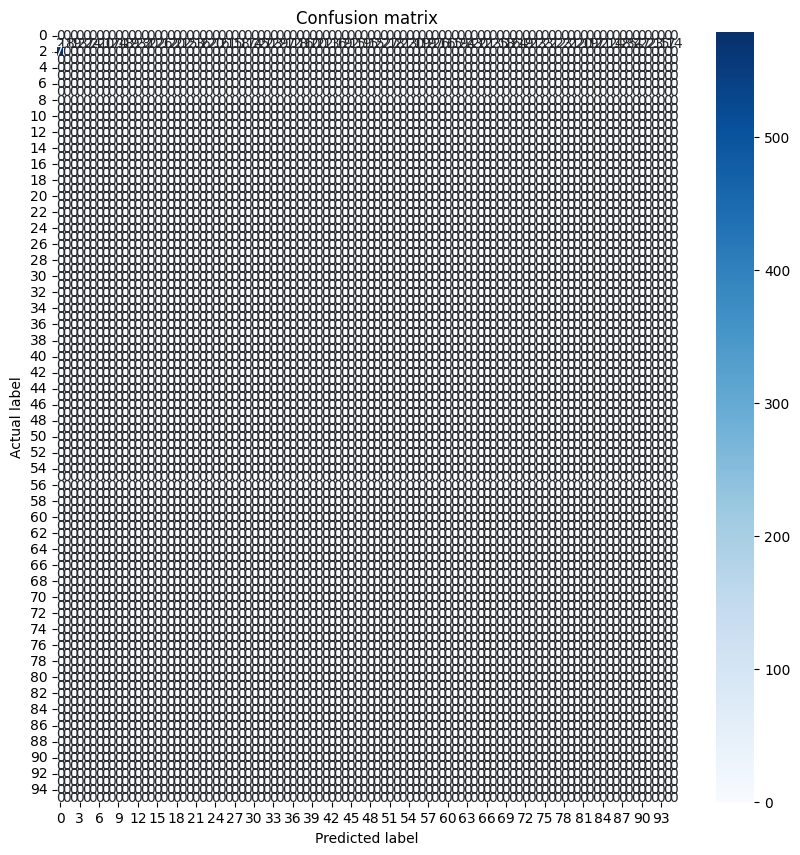

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# ROC

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_bin = label_binarize(y, classes=[-1, 1])
n_classes = y_bin.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=0))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# 각 클래스에 대해 ROC AUC를 계산합니다.
roc_auc = []
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc.append(auc(fpr, tpr))

# Precision과 Recall을 계산합니다.
y_test_multiclass = y_test.argmax(axis=1)
y_pred_multiclass = y_score.argmax(axis=1)

precision = precision_score(y_test_multiclass, y_pred_multiclass, average='macro')
recall = recall_score(y_test_multiclass, y_pred_multiclass, average='macro')

print("ROC AUC: ", roc_auc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))


ROC AUC:  [1.0, 0.9999289284783587]
Precision: 0.529
Recall: 0.945


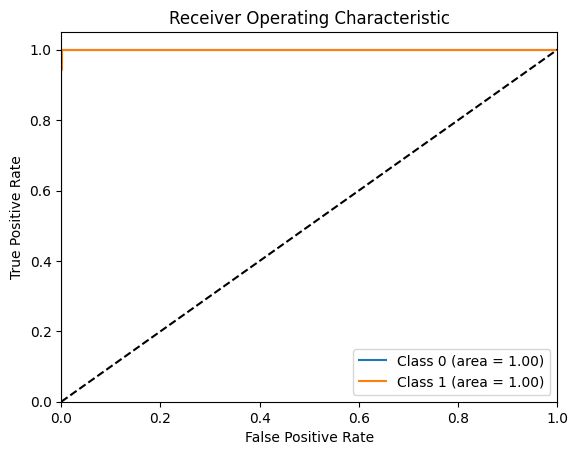

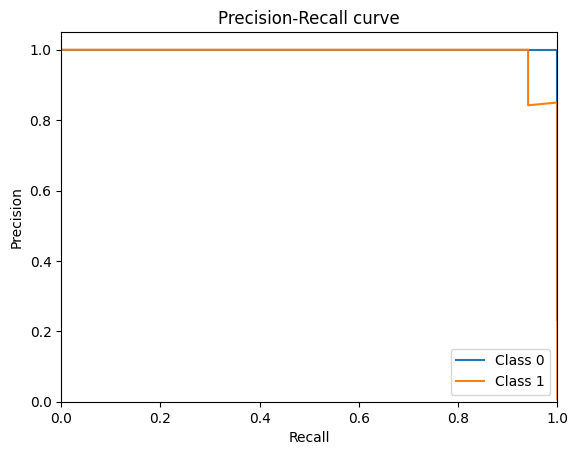

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC curve를 그립니다.
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (area = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve를 그립니다.
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    plt.plot(recall, precision, label='Class {}'.format(i))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()
